In [521]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [522]:
# read in all the words
words = [x.lower() for x in list(open('male_names_rus.txt', 'r').read().splitlines())]
words[:8]

['аарон',
 'аба',
 'аббас',
 'абд аль-узза',
 'абдуллах',
 'абид',
 'аботур',
 'аввакум']

In [523]:
len(words)

736

In [524]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '-', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'и', 12: 'й', 13: 'к', 14: 'л', 15: 'м', 16: 'н', 17: 'о', 18: 'п', 19: 'р', 20: 'с', 21: 'т', 22: 'у', 23: 'ф', 24: 'х', 25: 'ц', 26: 'ч', 27: 'ш', 28: 'ы', 29: 'ь', 30: 'э', 31: 'ю', 32: 'я', 33: 'ё', 0: '.'}


In [525]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [526]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([5285, 3]), torch.int64, torch.Size([5285]), torch.int64)

In [527]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([4206, 3]) torch.Size([4206])
torch.Size([550, 3]) torch.Size([550])
torch.Size([529, 3]) torch.Size([529])


In [528]:
C = torch.randn((34, 2))

In [529]:
emb = C[X]
emb.shape

torch.Size([5285, 3, 2])

In [530]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([4206, 3]), torch.Size([4206]))

In [531]:
g = torch.Generator().manual_seed(52) # for reproducibility
C = torch.randn((34, 10), generator=g)
W1 = torch.randn((30, 256), generator=g)
b1 = torch.randn(256, generator=g)
W2 = torch.randn((256, 256), generator=g)
b2 = torch.randn(256, generator=g)
W3 = torch.randn((256, 128), generator=g)
b3 = torch.randn(128, generator=g)
W4 = torch.randn((128, 128), generator=g)
b4 = torch.randn(128, generator=g)
W5 = torch.randn((128, 64), generator=g)
b5 = torch.randn(64, generator=g)
W6 = torch.randn((64, 34), generator=g)
b6 = torch.randn(34, generator=g)
parameters = [C, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6]

In [532]:
sum(p.nelement() for p in parameters) # number of parameters in total

133942

In [533]:
for p in parameters:
  p.requires_grad = True

In [534]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [535]:
lri = []
lossi = []
stepi = []
lossi_train = []

In [536]:
for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (256,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  h2 = torch.tanh(h @ W2 + b2)
  h3 = torch.tanh(h2 @ W3 + b3)
  h4 = torch.tanh(h3 @ W4 + b4)
  h5 = torch.tanh(h4 @ W5 + b5)
  logits = h5 @ W6 + b6
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10 == 0:
    ix = torch.randint(0, Xte.shape[0], (2048,))
    emb = C[Xte[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    h2 = torch.tanh(h @ W2 + b2)
    h3 = torch.tanh(h2 @ W3 + b3)
    h4 = torch.tanh(h3 @ W4 + b4)
    h5 = torch.tanh(h4 @ W5 + b5)
    logits = h5 @ W6 + b6
    loss_test = F.cross_entropy(logits, Yte[ix])
    stepi.append(i)
    lossi.append(loss_test.log10().item())
    lossi_train.append(loss.log10().item())
    print(f"Epoch: {i}; Loss_train: {loss.item()}; Loss_test: {loss_test.item()}")

#print(loss.item())

Epoch: 0; Loss_train: 15.972679138183594; Loss_test: 15.826802253723145
Epoch: 10; Loss_train: 16.201047897338867; Loss_test: 17.009048461914062
Epoch: 20; Loss_train: 15.23340892791748; Loss_test: 15.021787643432617
Epoch: 30; Loss_train: 13.95368766784668; Loss_test: 13.768603324890137
Epoch: 40; Loss_train: 12.478791236877441; Loss_test: 13.936296463012695
Epoch: 50; Loss_train: 12.0966157913208; Loss_test: 12.955263137817383
Epoch: 60; Loss_train: 12.666540145874023; Loss_test: 12.32068157196045
Epoch: 70; Loss_train: 10.956056594848633; Loss_test: 10.912505149841309
Epoch: 80; Loss_train: 11.189674377441406; Loss_test: 10.918619155883789
Epoch: 90; Loss_train: 10.842761039733887; Loss_test: 11.203324317932129
Epoch: 100; Loss_train: 10.35601806640625; Loss_test: 10.884560585021973
Epoch: 110; Loss_train: 9.272265434265137; Loss_test: 9.870902061462402
Epoch: 120; Loss_train: 9.495152473449707; Loss_test: 9.931142807006836
Epoch: 130; Loss_train: 9.698136329650879; Loss_test: 8.995

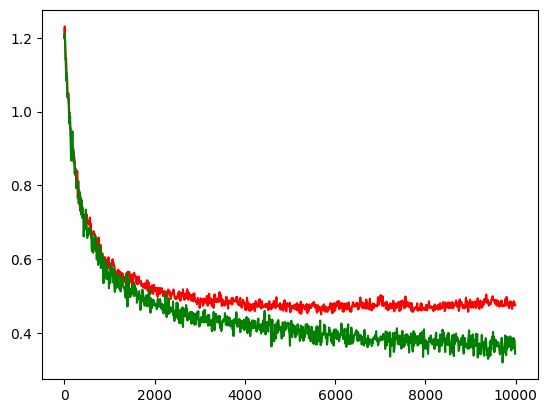

In [537]:
plt.plot(stepi, lossi, color='red')
plt.plot(stepi, lossi_train, color='green')

In [538]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
h2 = torch.tanh(h @ W2 + b2)
h3 = torch.tanh(h2 @ W3 + b3)
h4 = torch.tanh(h3 @ W4 + b4)
h5 = torch.tanh(h4 @ W5 + b5)
logits = h5 @ W6 + b6
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3325, grad_fn=<NllLossBackward0>)

In [539]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
h2 = torch.tanh(h @ W2 + b2)
h3 = torch.tanh(h2 @ W3 + b3)
h4 = torch.tanh(h3 @ W4 + b4)
h5 = torch.tanh(h4 @ W5 + b5)
logits = h5 @ W6 + b6
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.0548, grad_fn=<NllLossBackward0>)

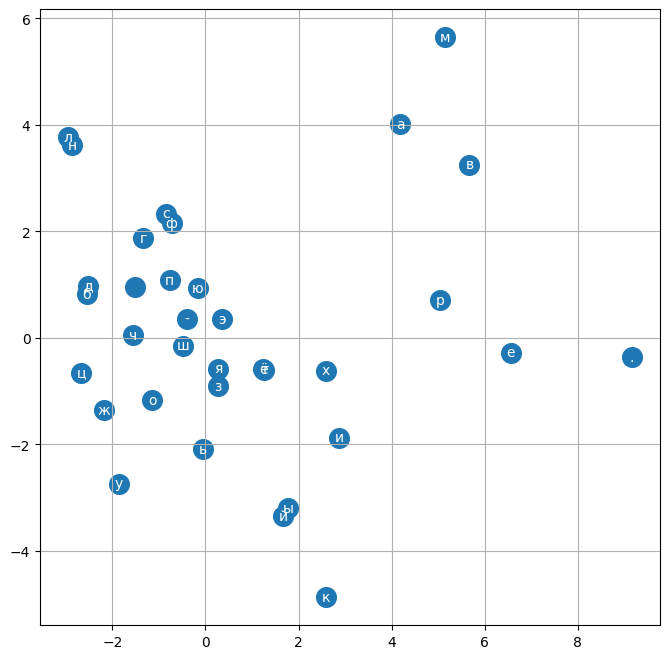

In [540]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [541]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [542]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [545]:


# sample from the model
g = torch.Generator().manual_seed(1)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      h2 = torch.tanh(h @ W2 + b2)
      h3 = torch.tanh(h2 @ W3 + b3)
      h4 = torch.tanh(h3 @ W4 + b4)
      h5 = torch.tanh(h4 @ W5 + b5)
      logits = h5 @ W6 + b6
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

анканер.
вовад.
дхер.
аоюер.
петенл.
орлйооеда-йоарас.
агварсеьефвшчойоруешейуанл.
гекв.
ипим.
рбубз.
элх.
омднсей.
лолодоринон.
верим.
рас.
раклут.
емисем.
кеалу.
ишросо.
омнтийстолид.
